# Topics (LDA) in Jira Support Tickets
## A Case Study of ES/4Students VS. WeLearnInBits

&copy; Anika Nissen

Based on and adapted from the steps described here: https://gist.github.com/sg-tarek/fac6e2da92744cdfd1e9b29201f4b614.js


In [1]:
#import importlib

# Import all of the required libs
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# This provides us the nlp pipeline for tokenization and pre-trained language models as well as sentiment analysis
import spacy
from spacy_sentiws import spaCySentiWS
#import en_core_web_md

# This provides the actual models that are used to create the different topics
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf as GensimNmf

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Additional imports for ngrams
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

/Users/anikanissen/opt/anaconda3/envs/JiraSupportTickets/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Step 1: Load the data and get an impression on the data structure

In [2]:
#Import data and have a look at data

reports = pd.read_excel('Jira Support_Export_clean.xlsx') 
reports.head()

,Vorgangstyp,Schlüssel,Zusammenfassung,Beschreibung,Zugewiesene Person,Autor,Priorität,Status,Erstellt,Aktualisiert
0,Support,SWELIB-2158,Nicht mehr im Kurs,"Hallo,\n\n\n\nich hatte den TS410 Kurs erfolgr...",Mareen Wienand,maseh_h@hotmail.de,High,Waiting for support,2022-10-16 23:16:05.364,2022-10-16 23:16:05.364
1,Support,SWELIB-2157,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"Hallo zusammen,\n\nIm Bereich “Purchase-To-Pay...",David Rumpf,fabian.kaudel@outlook.de,Medium,Geschlossen,2022-10-13 10:01:19.615,2022-10-15 13:49:51.413
2,Support,SWELIB-2156,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"Hallo zusammen,\n\n\n\nich bearbeite aktuell Ü...",David Rumpf,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-13 09:08:35.759,2022-10-16 16:37:40.070
3,Support,SWELIB-2155,Anmeldung zur Zertifikatsprüfung,"Guten Tag,\n\nich habe im Dezember letzten Jah...",David Rumpf,Andre.statnik@hotmail.de,High,Waiting for customer,2022-10-13 00:50:06.988,2022-10-13 21:37:35.281
4,Support,SWELIB-2154,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"Hallo zusammen,\n\n \n\naktuell hänge ich an A...",Kerem Yildirim,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-10 19:33:46.327,2022-10-11 17:00:52.151


In [3]:
# Get info on the data structure
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Vorgangstyp         2068 non-null   object        
 1   Schlüssel           2068 non-null   object        
 2   Zusammenfassung     2068 non-null   object        
 3   Beschreibung        1791 non-null   object        
 4   Zugewiesene Person  2046 non-null   object        
 5   Autor               2065 non-null   object        
 6   Priorität           2068 non-null   object        
 7   Status              2068 non-null   object        
 8   Erstellt            2068 non-null   datetime64[ns]
 9   Aktualisiert        2068 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(8)
memory usage: 161.7+ KB


In [4]:
# Drop rows with empty Beschreibung and merge Text written in Zusammenfassung and Beschreibung together into one column named "Abstract"
reports = reports[reports['Beschreibung'].notna()]

reports['Abstract'] = reports["Zusammenfassung"].map(str) + "-" + reports["Beschreibung"]
reports['Abstract']= reports['Abstract'].astype(str)
reports['Abstract']

0       Nicht mehr im Kurs-Hallo,\n\n\n\nich hatte den...
1       Purchase-To-Pay | Buch wird nicht als Abgeschl...
2       Fallstudie 1: Übung 17 - Zahlungsausgang buche...
3       Anmeldung zur Zertifikatsprüfung-Guten Tag,\n\...
4       Falsche EInheit hinterlegt in Aufgabe9 der Fal...
                              ...                        
2063    Abweichende Rechnungs- und Zustellungsadresse-...
2064    Probleme bei der Anmeldung-Ich habe Probleme b...
2065    Re: Willkommen bei es/4students-Sehr geehrte D...
2066    bachelor-ich finde nicht eine Sache in GUI Mac...
2067    Fragen...-Guten Tag, \n\nIch würde gerne Wisse...
Name: Abstract, Length: 2068, dtype: object

In [5]:
removewords = ['geehrte', 'Damen', 'Herren', 'freundlichen', 'grüßen', 'jira', 
               'eric schott','customer portal', 'unsubscriben', 'message from',
               'datenschutzerklärung', '--', "Hallo", "Guten Tag", "willkommen bei", 
               "es/4students", "\n"]

for i in removewords:
    reports['Abstract'] = reports['Abstract'].str.replace(i,' ', case=False)
    
reports['Abstract']    

0       Nicht mehr im Kurs- ,    ich hatte den TS410 K...
1       Purchase-To-Pay | Buch wird nicht als Abgeschl...
2       Fallstudie 1: Übung 17 - Zahlungsausgang buche...
3       Anmeldung zur Zertifikatsprüfung- ,  ich habe ...
4       Falsche EInheit hinterlegt in Aufgabe9 der Fal...
                              ...                        
2063    Abweichende Rechnungs- und Zustellungsadresse-...
2064    Probleme bei der Anmeldung-Ich habe Probleme b...
2065    Re:    -Sehr     und  ,  ich habe mich am 1. M...
2066    bachelor-ich finde nicht eine Sache in GUI Mac...
2067    Fragen...- ,   Ich würde gerne Wissen, wann de...
Name: Abstract, Length: 2068, dtype: object

## Step 2: Preprocess the data with SpaCy
Using Compilation of N-Grams and then the SpaCy Pipeline for Preprocessing of the data.
This draws on a general model which is pre-trained on a large body of German News Articles.

In [6]:
# Our spaCy model:
import de_core_news_sm
nlp = spacy.load('de_core_news_sm')
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [7]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'morphologizer',
 'parser',
 'lemmatizer',
 'attribute_ruler',
 'ner',
 'merge_noun_chunks',
 'merge_entities']

In [8]:
# This is a manual option to consider n-grams, however, this just chunks the text
# into bigrams and trigrams without understanding context
'''
# First let's define the ngrams:
def compile_ngrams(text, number_of_n=3, include_unigrams=True):
  ngram_list = []
  # number_of_n controls up to how many n we build an ngram for
  # 2 being bigrams, 3 being trigrams, ect.
  for n in range(number_of_n):
    if n == 0 and not include_unigrams:
      continue
    for ngram in ngrams(text.split(), n + 1):
      ngram_list.append(' '.join(ngram))
  return ngram_list

compile_ngrams('Abstract')
'''

"\n# First let's define the ngrams:\ndef compile_ngrams(text, number_of_n=3, include_unigrams=True):\n  ngram_list = []\n  # number_of_n controls up to how many n we build an ngram for\n  # 2 being bigrams, 3 being trigrams, ect.\n  for n in range(number_of_n):\n    if n == 0 and not include_unigrams:\n      continue\n    for ngram in ngrams(text.split(), n + 1):\n      ngram_list.append(' '.join(ngram))\n  return ngram_list\n\ncompile_ngrams('Abstract')\n"

In [9]:
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

# Looping through text to tokenize the whole thing
for summary in nlp.pipe(reports['Abstract']):
    proj_tok = [token.lemma_.lower() for token in summary 
                if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    
    #unigrams = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    #proj_tok = compile_ngrams(" ".join(unigrams), number_of_n=3, include_unigrams=False)

    tokens.append(proj_tok)

In [10]:
# Compute bigrams.
from gensim.models import Phrases

docs=reports['Abstract'].values.tolist()

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            tokens[idx].append(token)

In [11]:
reports['tokens'] = tokens
reports['tokens']

0       [absolvieren, zertifizierung, erhalten, april,...
1       [bereich, markieren, melden, dato, erhalten, m...
2       [buchen, bearbeiten, übung, wert, anzeigen, ve...
3       [anmeldung, dezember, zertifizierung, bestelle...
4       [hinterlegen, hängen, aufgabe, ziel, finden, l...
                              ...                        
2063                               [abweichende, angeben]
2064    [problem, problem, passwort, erhalten, zurückz...
2065    [anmelden, erhalten, einloggen, beginnen, verp...
2066    [finden, herunterladen, macen, installieren, e...
2067             [frage, wissen, sap, beginnen, bekommen]
Name: tokens, Length: 2068, dtype: object

## Step 3: Create dictionary and corpus
The two main inputs to the LDA topic model are the dictionary and the corpus:
* Dictionary: The idea of the dictionary is to give each token a unique ID.
* Corpus: Having assigned a unique ID to each token, the corpus simply contains each ID and its frequency (if you wanna dive into it, then search for Bag of Word (BoW) which will introduce you to word embedding).

In [12]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])

In [13]:
#print(dictionary.token2id)
dict(list(dictionary.token2id.items())[:20])

{'absolvieren': 0,
 'april': 1,
 'bitte': 2,
 'einloggen': 3,
 'einschreiben': 4,
 'eintragen': 5,
 'erhalten': 6,
 'kurs': 7,
 'tragen': 8,
 'vorbereiten': 9,
 'zertifizierung': 10,
 'bereich': 11,
 'dato': 12,
 'machen': 13,
 'markieren': 14,
 'melden': 15,
 'anzeigen': 16,
 'bearbeiten': 17,
 'besitzen': 18,
 'buchen': 19}

In the following, I will filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words:
* No_below: Tokens that appear in less than 5 documents are filtered out.
* No_above: Tokens that appear in more than 60% of the total corpus are also removed as default.
* Keep_n: We limit ourselves to the top 1000 most frequent tokens (default is 100.000). Set to ‘None’ if you want to keep all.

In [14]:
dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=1000)

In [15]:
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

In [16]:
reports.head()

,Vorgangstyp,Schlüssel,Zusammenfassung,Beschreibung,Zugewiesene Person,Autor,Priorität,Status,Erstellt,Aktualisiert,Abstract,tokens
0,Support,SWELIB-2158,Nicht mehr im Kurs,"Hallo,\n\n\n\nich hatte den TS410 Kurs erfolgr...",Mareen Wienand,maseh_h@hotmail.de,High,Waiting for support,2022-10-16 23:16:05.364,2022-10-16 23:16:05.364,"Nicht mehr im Kurs- , ich hatte den TS410 K...","[absolvieren, zertifizierung, erhalten, april,..."
1,Support,SWELIB-2157,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"Hallo zusammen,\n\nIm Bereich “Purchase-To-Pay...",David Rumpf,fabian.kaudel@outlook.de,Medium,Geschlossen,2022-10-13 10:01:19.615,2022-10-15 13:49:51.413,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"[bereich, markieren, melden, dato, erhalten, m..."
2,Support,SWELIB-2156,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"Hallo zusammen,\n\n\n\nich bearbeite aktuell Ü...",David Rumpf,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-13 09:08:35.759,2022-10-16 16:37:40.070,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"[buchen, bearbeiten, übung, wert, anzeigen, ve..."
3,Support,SWELIB-2155,Anmeldung zur Zertifikatsprüfung,"Guten Tag,\n\nich habe im Dezember letzten Jah...",David Rumpf,Andre.statnik@hotmail.de,High,Waiting for customer,2022-10-13 00:50:06.988,2022-10-13 21:37:35.281,"Anmeldung zur Zertifikatsprüfung- , ich habe ...","[anmeldung, dezember, zertifizierung, bestelle..."
4,Support,SWELIB-2154,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"Hallo zusammen,\n\n \n\naktuell hänge ich an A...",Kerem Yildirim,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-10 19:33:46.327,2022-10-11 17:00:52.151,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"[hinterlegen, hängen, aufgabe, ziel, finden, l..."


## Step 4: Model building
Now let's run the LDA Model over the dictionary and text for several different number of output topics and take a look at the topic coherence. This can be used to select an appropriate number of topics. More precisely, a range of different algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). In this notebook, we will implement the UMASS, CV, and the NPMI score. 

### Step 4A: U_Mass Coherence Score
This way to calculate topic coherence was developed by Mimno et al. (2011). Generally, the lower the UMass score and the higher the CV score in coherence, the better the model (Sarkar 2019). Generally, in the gensim library a umass coherence closer to 0 is better.


References:
* Mimno, D., Wallach, H. M., Talley, E., Leenders, M., & McCallum, A. (2011). Optimizing semantic coherence in topic models. EMNLP 2011 - Conference on Empirical Methods in Natural Language Processing, Proceedings of the Conference, 2, 262–272.
* Röder, M., Both, A., & Hinneburg, A. (2015). Exploring the space of topic coherence measures. WSDM 2015 - Proceedings of the 8th ACM International Conference on Web Search and Data Mining, 399–408. https://doi.org/10.1145/2684822.2685324
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1

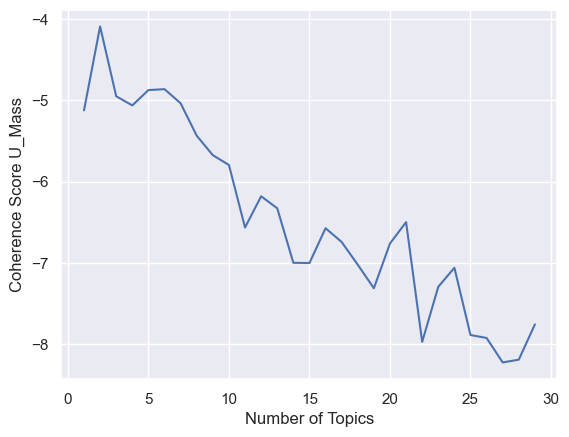

In [17]:
#Calculating the coherence score using C_umass:
topics_umass = []
score_umass = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics_umass.append(i)
   score_umass.append(cm.get_coherence())
_=plt.plot(topics_umass, score_umass)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score U_Mass')
plt.show()

In [18]:
coherence_umass = pd.DataFrame({'Number of Topics': topics_umass,
                               'Coherence Score': score_umass})
coherence_umass['Sorted'] = coherence_umass['Coherence Score'].abs()
coherence_umass.sort_values(by=['Sorted'], ascending = True).head(10)

,Number of Topics,Coherence Score,Sorted
1,2,-4.093645,4.093645
5,6,-4.864395,4.864395
4,5,-4.875847,4.875847
2,3,-4.951934,4.951934
6,7,-5.037956,5.037956
3,4,-5.064142,5.064142
0,1,-5.125238,5.125238
7,8,-5.436873,5.436873
8,9,-5.676025,5.676025
9,10,-5.796255,5.796255


### Step 3b: CV Coherence Score
The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). According to McLevey (2021), values above 0.5 can be regarded as fairly good. However, the higher the average CV score, the better is the coherence of the number of topics (Sarkar 2019, Mishra 2022).

References:
* Mishra, M. (2022). Customer Experience: Extracting Topics From Tweets. International Journal of Market Research, 64(3), 334–353. https://doi.org/10.1177/14707853211047515
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1
* McLevey, J. (2021). Doing Computational Social Science: A Practical Introduction. SAGE Publications.

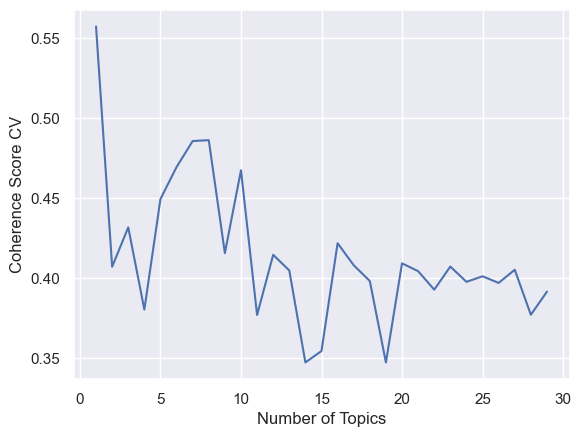

In [19]:
#Calculating the coherence score using C_v
topics_cv = []
score_cv = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics_cv.append(i)
   score_cv.append(cm.get_coherence())
_=plt.plot(topics_cv, score_cv)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score CV')
plt.show()

In [20]:
coherence_v = pd.DataFrame({'Number of Topics': topics_cv,
                               'Coherence Score': score_cv})
coherence_v['Sorted'] = coherence_v['Coherence Score'].abs()
coherence_v.sort_values(by=['Sorted'], ascending = False).head(10)

# According to the output here, 1 topic has the highest coherence (C_V = 0.557),
# followed by 3 topics (C_V = 0.486) and 9 topics (C_V = 0.486)

,Number of Topics,Coherence Score,Sorted
0,1,0.557171,0.557171
7,8,0.486222,0.486222
6,7,0.485665,0.485665
5,6,0.469444,0.469444
9,10,0.467428,0.467428
4,5,0.449508,0.449508
2,3,0.431813,0.431813
15,16,0.421919,0.421919
8,9,0.415733,0.415733
11,12,0.414691,0.414691


### Step 3c: NPMI Coherence Score
The coherence score for C_NPMI is similar to UMASS as values closer to 0 have better coherence than larger values.

References:
* Röder, M., Both, A., & Hinneburg, A. (2015). Exploring the space of topic coherence measures. WSDM 2015 - Proceedings of the 8th ACM International Conference on Web Search and Data Mining, 399–408. https://doi.org/10.1145/2684822.2685324
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1

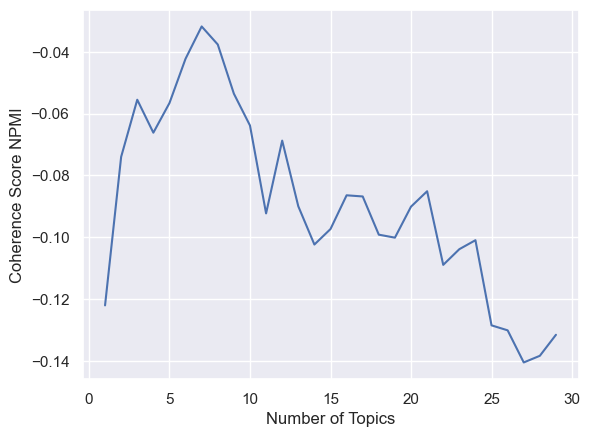

In [21]:
#Calculating the coherence score using C_npmi
topics_npmi = []
score_npmi = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_npmi')
   topics_npmi.append(i)
   score_npmi.append(cm.get_coherence())
_=plt.plot(topics_npmi, score_npmi)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score NPMI')
plt.show()

In [22]:
coherence_npmi = pd.DataFrame({'Number of Topics': topics_npmi,
                               'Coherence Score': score_npmi})
coherence_npmi['Sorted'] = coherence_npmi['Coherence Score'].abs()
coherence_npmi.sort_values(by=['Sorted'], ascending = True).head(10)

# According to the output here, 5 topics have the highest coherence (C_npmi = -0.032),
# followed by 9 topics (C_npmi = -0.038) and 7 topics (C_npmi = -0.042)

,Number of Topics,Coherence Score,Sorted
6,7,-0.031832,0.031832
7,8,-0.037671,0.037671
5,6,-0.042263,0.042263
8,9,-0.053576,0.053576
2,3,-0.055534,0.055534
4,5,-0.056605,0.056605
9,10,-0.063869,0.063869
3,4,-0.066191,0.066191
11,12,-0.068753,0.068753
1,2,-0.073995,0.073995


## Step 5: Running the Final Model
Adapting the model according to the optimal number of topics based on the calculated coherence scores. 
As in all three calculated score, the number of 9 topics was among the 3 highest coherence score, we will use 9 topics to calculate the model.

In [23]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, 
                         num_topics=9, workers = 8, passes=100)

## Step 6: Extract and Visualize the Topics
We can now print out the five topics and the related words:

In [24]:
lda_model.print_topics()

[(0,
  '0.033*"verlängern" + 0.026*"lesen" + 0.025*"erhalten" + 0.023*"akzeptieren" + 0.023*"finden" + 0.023*"bitte" + 0.021*"kurs" + 0.020*"voraus" + 0.020*"vergessen" + 0.019*"enden"'),
 (1,
  '0.069*"schritt" + 0.049*"finden" + 0.036*"anzeigen" + 0.033*"übung" + 0.030*"buchen" + 0.021*"to" + 0.019*"erstellen" + 0.018*"drücken" + 0.018*"order" + 0.017*"order_to"'),
 (2,
  '0.054*"sehen" + 0.049*"anzeigen" + 0.047*"anlegen" + 0.046*"bearbeiten" + 0.025*"erscheinen" + 0.023*"anhang" + 0.021*"öffnen" + 0.019*"bekommen" + 0.018*"finden" + 0.017*"klicken"'),
 (3,
  '0.059*"portal" + 0.052*"schreiben" + 0.042*"customer" + 0.042*"customer_portal" + 0.039*"jwt" + 0.033*"software" + 0.030*"color" + 0.030*"by" + 0.028*"aw" + 0.022*"this"'),
 (4,
  '0.439*"nan" + 0.058*"übung" + 0.040*"kapitel" + 0.036*"fallstudie" + 0.022*"erfasst" + 0.018*"liefern" + 0.017*"müssten" + 0.014*"anzeige" + 0.013*"freigeben" + 0.013*"bestellen"'),
 (5,
  '0.148*"--" + 0.099*"to" + 0.042*"the" + 0.032*"i" + 0.027*"

In [25]:
# Let’s look at our first report summary:
reports['Abstract'][0]

#According to our LDA model, the above text belongs to Topic 2 and 4. 
#The article is 87% belonging to topic 2 (index 1) and 12% belonging to topic 4 (index 3).
lda_model[corpus][0]

[(8, 0.9258958)]

### Interactive Visualization of Topics with pyLDAvis
The above chart represents our five topics as circles. They have been drawn using a dimensionality reduction technique called PCA. The goal is to have a distance in order to avoid overlapping and make each circle unique. When I hover over a circle different words are displayed on the right, showing word frequency (blue) and estimated term frequency within the selected topic (red). Topics closer to each other are more related.

In [26]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/anikanissen/opt/anaconda3/envs/JiraSupportTickets/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/anikanissen/opt/anaconda3/envs/JiraSupportTickets/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/JiraSupportTickets/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/JiraSupportTickets/lib/python3.10/site-packages/past/bui

In [27]:
# Save the report
pyLDAvis.save_html(lda_display, 'LDA_VIS_Jira_Tickets.html')

### Add topics to dataframe
We can create a new column in the dataframe which has the most probable topic that each article belong to. We can add the most probable topic by running through each summary text:

In [28]:
lda_model[corpus][1]

[(0, 0.022238338),
 (1, 0.22583187),
 (2, 0.022226295),
 (3, 0.022226794),
 (4, 0.02222358),
 (5, 0.02222325),
 (6, 0.02222325),
 (7, 0.6185526),
 (8, 0.022254026)]

In [29]:
reports['topic_ID'] = [sorted(lda_model[corpus][text])[0][0] 
                       for text in range(len(reports['Abstract']))]

In [35]:
reports

,Vorgangstyp,Schlüssel,Zusammenfassung,Beschreibung,Zugewiesene Person,Autor,Priorität,Status,Erstellt,Aktualisiert,Abstract,tokens,topic_ID,topic
0,Support,SWELIB-2158,Nicht mehr im Kurs,"Hallo,\n\n\n\nich hatte den TS410 Kurs erfolgr...",Mareen Wienand,maseh_h@hotmail.de,High,Waiting for support,2022-10-16 23:16:05.364,2022-10-16 23:16:05.364,"Nicht mehr im Kurs- , ich hatte den TS410 K...","[absolvieren, zertifizierung, erhalten, april,...",8,8
1,Support,SWELIB-2157,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"Hallo zusammen,\n\nIm Bereich “Purchase-To-Pay...",David Rumpf,fabian.kaudel@outlook.de,Medium,Geschlossen,2022-10-13 10:01:19.615,2022-10-15 13:49:51.413,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"[bereich, markieren, melden, dato, erhalten, m...",0,0
2,Support,SWELIB-2156,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"Hallo zusammen,\n\n\n\nich bearbeite aktuell Ü...",David Rumpf,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-13 09:08:35.759,2022-10-16 16:37:40.070,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"[buchen, bearbeiten, übung, wert, anzeigen, ve...",1,1
3,Support,SWELIB-2155,Anmeldung zur Zertifikatsprüfung,"Guten Tag,\n\nich habe im Dezember letzten Jah...",David Rumpf,Andre.statnik@hotmail.de,High,Waiting for customer,2022-10-13 00:50:06.988,2022-10-13 21:37:35.281,"Anmeldung zur Zertifikatsprüfung- , ich habe ...","[anmeldung, dezember, zertifizierung, bestelle...",0,0
4,Support,SWELIB-2154,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"Hallo zusammen,\n\n \n\naktuell hänge ich an A...",Kerem Yildirim,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-10 19:33:46.327,2022-10-11 17:00:52.151,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"[hinterlegen, hängen, aufgabe, ziel, finden, l...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,Support,SWELIB-24,Abweichende Rechnungs- und Zustellungsadresse,"Sehr geehrte Damen und Herren,\n\nich würde ge...",Ehemaliger Benutzer,alexandraklein.x3@gmail.com,High,Geschlossen,2019-05-07 13:40:01.723,2019-09-07 10:00:37.750,Abweichende Rechnungs- und Zustellungsadresse-...,"[abweichende, angeben]",0,0
2064,Support,SWELIB-23,Probleme bei der Anmeldung,"Ich habe Probleme bei der Anmeldung, da ich tr...",Ehemaliger Benutzer,noahleu@yahoo.de,High,Geschlossen,2019-05-06 11:57:46.765,2019-09-07 10:00:37.547,Probleme bei der Anmeldung-Ich habe Probleme b...,"[problem, problem, passwort, erhalten, zurückz...",0,0
2065,Support,SWELIB-20,Re: Willkommen bei es/4students,"Sehr geehrte Damen und Herren,\n\nich habe mic...",NaN,peymud@gmail.com,High,Geschlossen,2019-05-05 13:41:50.328,2019-09-07 10:00:37.428,"Re: -Sehr und , ich habe mich am 1. M...","[anmelden, erhalten, einloggen, beginnen, verp...",0,0
2066,Support,SWELIB-19,bachelor,ich finde nicht eine Sache in GUI Mac und desh...,NaN,liuyangtest123@gmail.com,Medium,Geschlossen,2019-05-02 15:33:17.180,2019-09-07 10:00:37.507,bachelor-ich finde nicht eine Sache in GUI Mac...,"[finden, herunterladen, macen, installieren, e...",0,0


In [36]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Vorgangstyp         2068 non-null   object        
 1   Schlüssel           2068 non-null   object        
 2   Zusammenfassung     2068 non-null   object        
 3   Beschreibung        1791 non-null   object        
 4   Zugewiesene Person  2046 non-null   object        
 5   Autor               2065 non-null   object        
 6   Priorität           2068 non-null   object        
 7   Status              2068 non-null   object        
 8   Erstellt            2068 non-null   datetime64[ns]
 9   Aktualisiert        2068 non-null   datetime64[ns]
 10  Abstract            2068 non-null   object        
 11  tokens              2068 non-null   object        
 12  topic_ID            2068 non-null   int64         
 13  topic               2068 non-null   int64       

In [57]:
reports['topic'] = reports['topic_ID']

In [58]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Vorgangstyp         2068 non-null   object        
 1   Schlüssel           2068 non-null   object        
 2   Zusammenfassung     2068 non-null   object        
 3   Beschreibung        1791 non-null   object        
 4   Zugewiesene Person  2046 non-null   object        
 5   Autor               2065 non-null   object        
 6   Priorität           2068 non-null   object        
 7   Status              2068 non-null   object        
 8   Erstellt            2068 non-null   datetime64[ns]
 9   Aktualisiert        2068 non-null   datetime64[ns]
 10  Abstract            2068 non-null   object        
 11  tokens              2068 non-null   object        
 12  topic_ID            2068 non-null   int64         
 13  topic               2068 non-null   int64       

In [59]:
for i in range(0, 9):
    reports['topic'] = reports['topic'].replace(to_replace =[i], value = lda_model.print_topics()[i][1])
    
reports.head()

,Vorgangstyp,Schlüssel,Zusammenfassung,Beschreibung,Zugewiesene Person,Autor,Priorität,Status,Erstellt,Aktualisiert,Abstract,tokens,topic_ID,topic
0,Support,SWELIB-2158,Nicht mehr im Kurs,"Hallo,\n\n\n\nich hatte den TS410 Kurs erfolgr...",Mareen Wienand,maseh_h@hotmail.de,High,Waiting for support,2022-10-16 23:16:05.364,2022-10-16 23:16:05.364,"Nicht mehr im Kurs- , ich hatte den TS410 K...","[absolvieren, zertifizierung, erhalten, april,...",8,"0.062*""abschließen"" + 0.060*""erhalten"" + 0.040..."
1,Support,SWELIB-2157,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"Hallo zusammen,\n\nIm Bereich “Purchase-To-Pay...",David Rumpf,fabian.kaudel@outlook.de,Medium,Geschlossen,2022-10-13 10:01:19.615,2022-10-15 13:49:51.413,Purchase-To-Pay | Buch wird nicht als Abgeschl...,"[bereich, markieren, melden, dato, erhalten, m...",0,"0.033*""verlängern"" + 0.026*""lesen"" + 0.025*""er..."
2,Support,SWELIB-2156,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"Hallo zusammen,\n\n\n\nich bearbeite aktuell Ü...",David Rumpf,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-13 09:08:35.759,2022-10-16 16:37:40.070,Fallstudie 1: Übung 17 - Zahlungsausgang buche...,"[buchen, bearbeiten, übung, wert, anzeigen, ve...",1,"0.069*""schritt"" + 0.049*""finden"" + 0.036*""anze..."
3,Support,SWELIB-2155,Anmeldung zur Zertifikatsprüfung,"Guten Tag,\n\nich habe im Dezember letzten Jah...",David Rumpf,Andre.statnik@hotmail.de,High,Waiting for customer,2022-10-13 00:50:06.988,2022-10-13 21:37:35.281,"Anmeldung zur Zertifikatsprüfung- , ich habe ...","[anmeldung, dezember, zertifizierung, bestelle...",0,"0.033*""verlängern"" + 0.026*""lesen"" + 0.025*""er..."
4,Support,SWELIB-2154,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"Hallo zusammen,\n\n \n\naktuell hänge ich an A...",Kerem Yildirim,fabian.kaudel@outlook.de,Medium,Waiting for customer,2022-10-10 19:33:46.327,2022-10-11 17:00:52.151,Falsche EInheit hinterlegt in Aufgabe9 der Fal...,"[hinterlegen, hängen, aufgabe, ziel, finden, l...",0,"0.033*""verlängern"" + 0.026*""lesen"" + 0.025*""er..."


In [60]:
reports.to_csv('./LDATopicResults.csv', index = True)